地理空間情報を扱うための自作モジュール使い方Memo
===
---
`geo_util.py`にまとめてみた。

ちゃんとしたモジュールにはしていない

#### 参考URL
- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)

## 0. 準備

In [1]:
# これの使い方
from geo_util import MapTile

#  その他
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

## 1. 実装内容
### 1.1. MapTileクラス
#### 1.1.1. 概要
- 座標・タイルの種類をもとに地理院タイルを取得して保持するクラス。指定された領域に属する全てのタイルをダウンロードし、一つのNumpy arrayとして扱うことが可能になる。

- 例えば、以下の画像で5/27/11から5/28/13までの縦長領域に関して好きなズームレベル6（5ではなく！）で標高タイルを取得したいとする。
このとき、MapTileクラスを使って
~~~python
japan_tile = MapTile([5, 27, 11], [5, 28, 13], zoom=6, tile_type="dem", ext="txt")
~~~
とすれば、`japan_tile.data`が標高を収めたNumpy arrayとなる。
タイル座標は[タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)で確認することができる。
<img src="fig/japan.png" width="300">


- また、`gx, gy = japan_tile.grad(x, y)`のようにすると、タイル上の座標(x, y)（インデックスに対応）における勾配gx, gyを得ることができる。(x, y)整数でなくても良い。

#### 1.1.2. 実装のポイント
- 引数で指定されたタイル座標の領域について、指定されたズームレベルにおけるタイル座標をすべて取得する必要がある。
ズームレベルを1つ増やすごとにタイルが4倍になり、下図のようにタイル座標が変化することを用いて実装している。
<img src="fig/zoom.jpg" width="300">

- 勾配の計算：
地理院タイルでは格子点上の標高が記されている（下図の正方形の頂点）。その隙間の任意の地点$(x, y)$での勾配を知りたいので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。
<img src="fig/grad.png", width=300></img>

(1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

   3点 $([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$


(2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

   3点 $([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

- 勾配の角度・絶対値
勾配の角度と絶対値は以下のようになる。
$$
\begin{align}
\theta = arctan(\frac{\partial z / \partial y}{\partial z / \partial x}) \\
|\;grad\;| = \sqrt{(\frac{\partial z}{\partial x})^2 + (\frac{\partial z}{\partial y})^2}
\end{align}
$$

## 2. 使い方

### 2.1. MapTileクラス
- [1. 実装内容](#1.-実装内容)に記した例：標高タイル

data=[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] 

 shape=(1536, 1024)


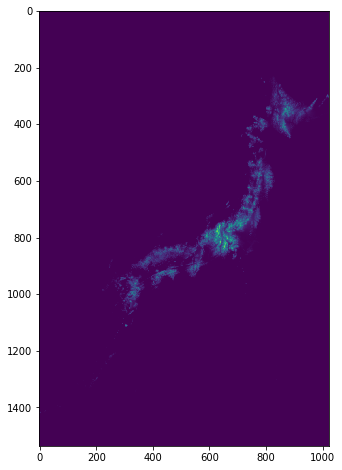

In [7]:
japan_tile = MapTile([5, 27, 11], [5, 28, 13], zoom=6, tile_type="dem", ext="txt")

figsize(12, 8)
plt.imshow(japan_tile.data)

# Attributes
print("data={} \n\n shape={}".format(japan_tile.data, japan_tile.shape))

- 標高タイル(csv)ではなく標準地図(png)の場合

data type =<class 'numpy.ndarray'> 

 shape=(256, 256, 3)


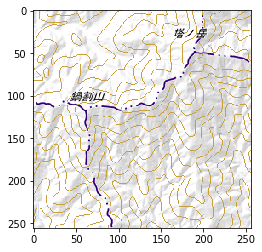

In [23]:
# 単一のタイル領域のみ指定したいときは以下のようにto_tileを省略すれば良い
# また、タイル領域の指定に用いたズームレベルのままでよければzoomを省略できる。
# TODO: 画像でzoomを別途指定するとエラーになるっぽい
nabewari_img = MapTile([13, 7262, 3232], tile_type="std", ext="png")
figsize(4, 4)
plt.imshow(nabewari_img.data)

# Attributes
print("data type ={} \n\n shape={}".format(type(nabewari_img.data), nabewari_img.shape))

- 勾配を利用する例

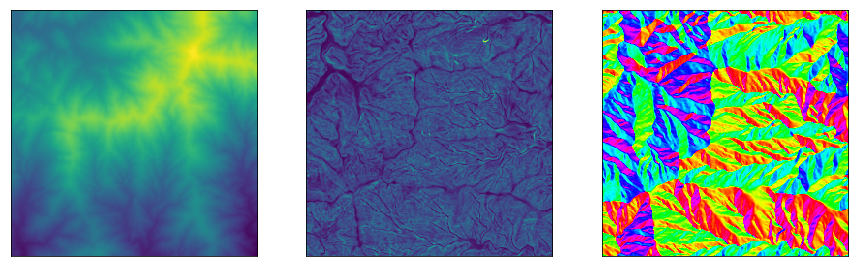

In [24]:
# 標高タイル
nabewari_tile= MapTile([13, 7262, 3232], tile_type="dem", ext="txt")
# 勾配の絶対値
norm = np.array([[nabewari_tile.grad_norm(i, j) for j in range(255)] for i in range(255)])
# 勾配の方向
angle = np.array([[nabewari_tile.grad_angle(i, j) for j in range(255)] for i in range(255)])

figsize(15, 5)
fig = plt.figure()
ax1 = fig.add_subplot(131, xticks=[], yticks=[])
ax1.imshow(nabewari_tile.data)
ax2 = fig.add_subplot(132, xticks=[], yticks=[])
ax2.imshow(norm)
ax3 = fig.add_subplot(133, xticks=[], yticks=[])
ax3.imshow(angle, cmap="hsv")